In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import pandas_gbq as pd_gbq
import gc
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from matplotlib import pyplot as plt
from google.cloud import bigquery
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from pandas_profiling import ProfileReport

%load_ext google.cloud.bigquery


/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [2]:
#Train data
bqclient = bigquery.Client()

query_string = """
SELECT * FROM `crack-petal-363512.Amex.Train`
"""

#select a.*,b.target from
#(SELECT * FROM `amexcds4.amextaiwan.amextaiwantrain`) a
#left join
#(SELECT * FROM `amexcds4.amextaiwan.trainLabels`) b
#on a.customer_ID	 = b.customer_ID;

dataframe = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        create_bqstorage_client=True,
    )
)


In [3]:
#Train label
bqclient = bigquery.Client()

query_string = """
SELECT * FROM `crack-petal-363512.Amex.Train_Label`
"""

dataframe_labels = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        create_bqstorage_client=True,
    )
)

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage before optimization is: {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [6]:
dataframe=reduce_mem_usage(dataframe)

Memory usage before optimization is: 8018.31 MB
Memory usage after optimization is: 2125.91 MB
Decreased by 73.5%


In [14]:
profile_train = ProfileReport(dataframe, title="Train Profiling Report", minimal=True)
profile_train.to_file(output_file="output_min.html")

Summarize dataset:   1%|          | 1/195 [00:08<26:19,  8.14s/it, Describe variable:S_2]/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:192: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 72.87it/s]


In [12]:
dataframe = pd.merge(dataframe,dataframe_labels, how='left', on='customer_ID')

In [5]:
cat_cols=['customer_ID', 'S_2', 'D_63', 'D_64']
del_cols = [c for c in dataframe.columns if (c.startswith(('D','t')) or c in 'traget' ) & (c not in cat_cols)]
df_del = dataframe[del_cols]
spd_cols = [c for c in dataframe.columns if (c.startswith(('S','t')) or c in 'traget' ) & (c not in cat_cols)]
df_spd = dataframe[spd_cols]
pay_cols = [c for c in dataframe.columns if (c.startswith(('P','t')) or c in 'traget' ) & (c not in cat_cols)]
df_pay = dataframe[pay_cols]
bal_cols = [c for c in dataframe.columns if (c.startswith(('B','t')) or c in 'traget' ) & (c not in cat_cols)]
df_bal = dataframe[bal_cols]
ris_cols = [c for c in dataframe.columns if (c.startswith(('R','t')) or c in 'traget' ) & (c not in cat_cols)]
df_ris = dataframe[ris_cols]

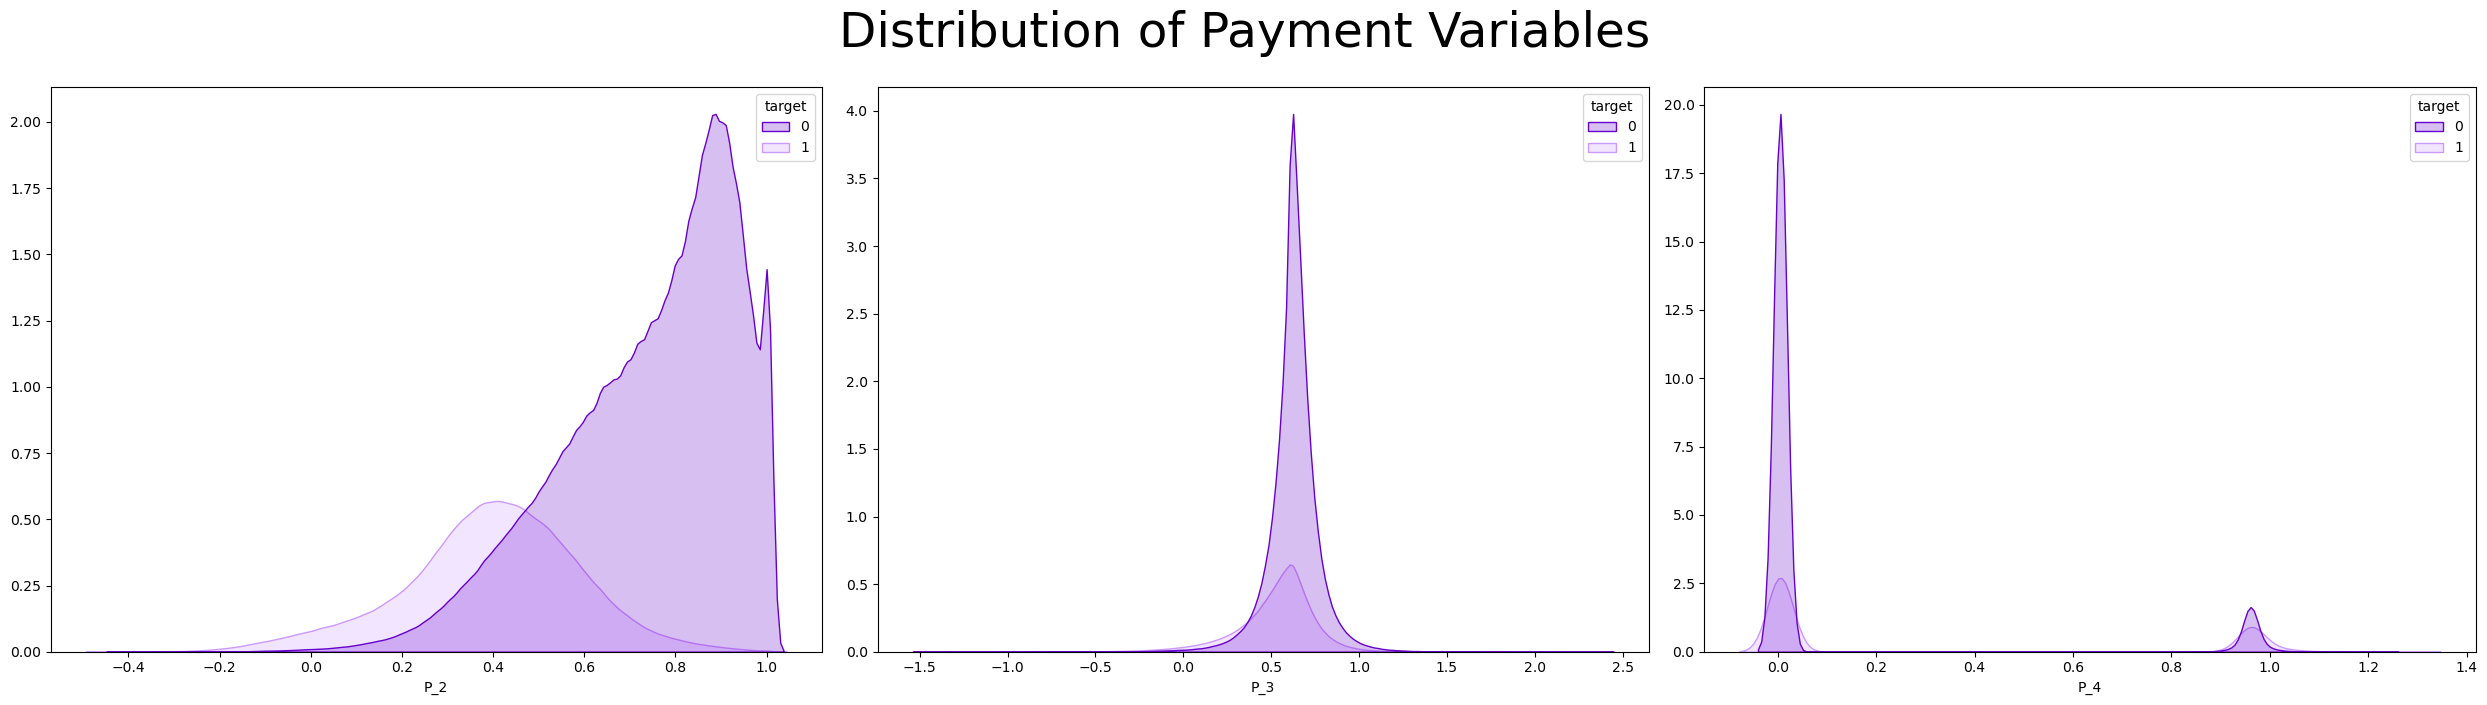

In [11]:
fig, axes = plt.subplots(1, 3, figsize = (25,7))
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(pay_cols):
        sns.kdeplot(x = pay_cols[i], hue='target', data = df_pay, fill = True, ax = ax, palette =["#6600cc","#cc99ff"])
        ax.tick_params()
        ax.xaxis.get_label()
        ax.set_ylabel('')
fig.suptitle('Distribution of Payment Variables', fontsize = 35, x = 0.5, y = 1)
plt.tight_layout()
plt.show()


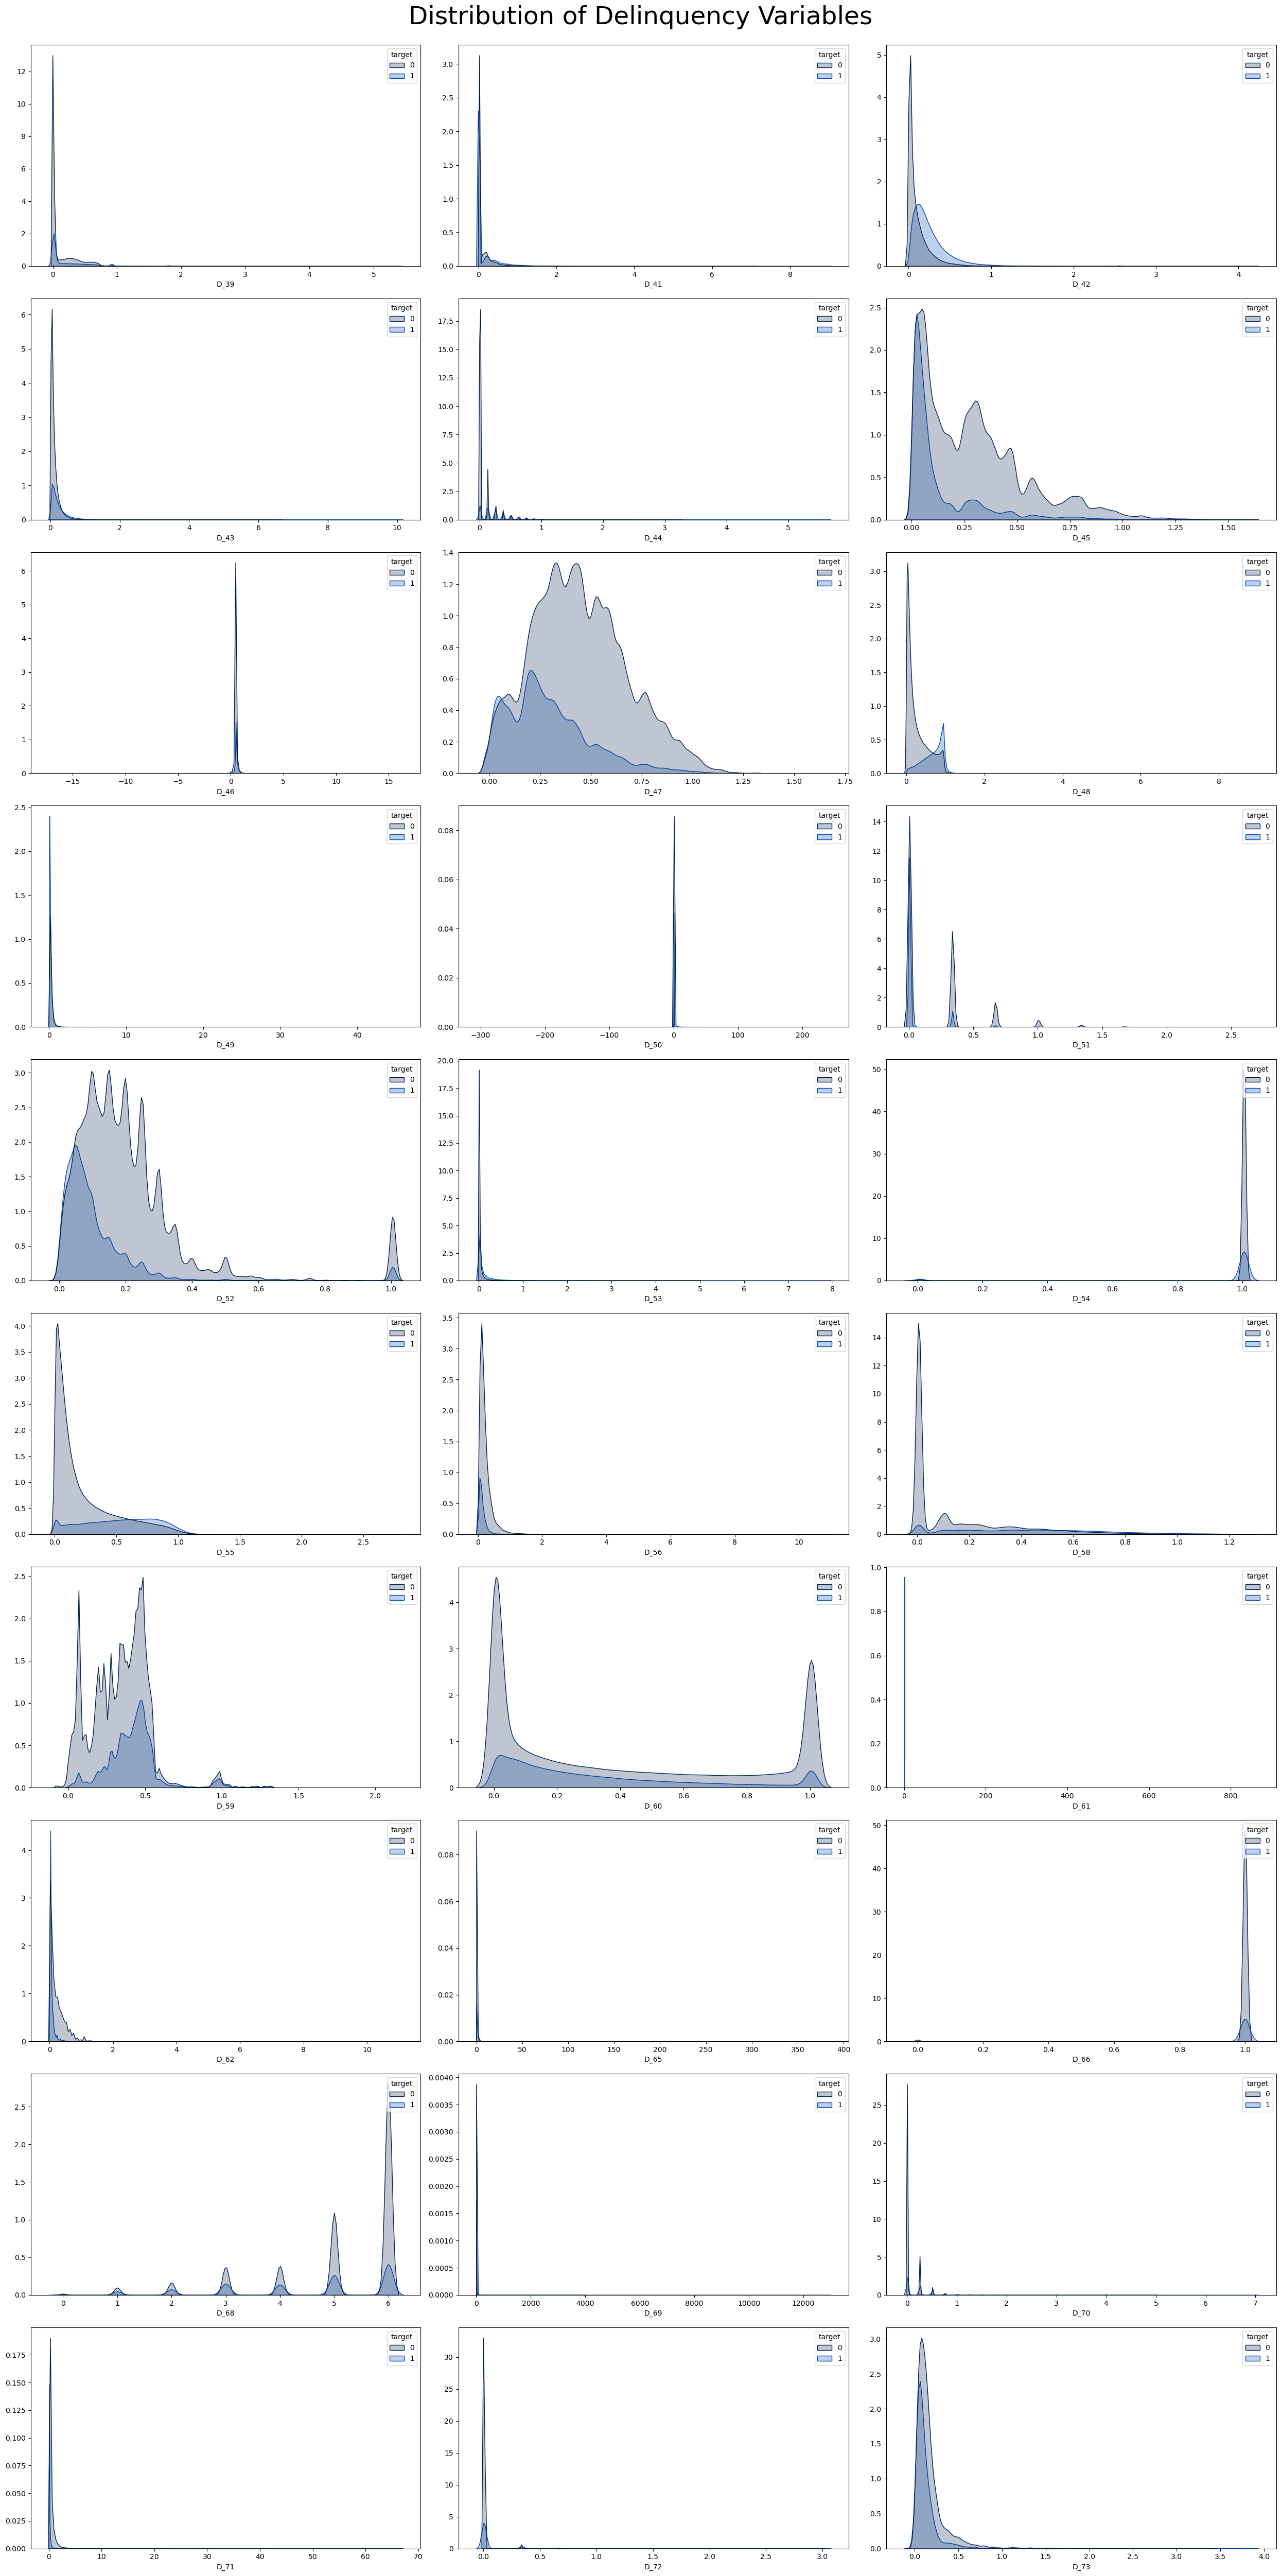

In [7]:
fig, axes = plt.subplots(10, 3, figsize = (25,50))
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(del_cols):
        sns.kdeplot(x = del_cols[i], hue='target', data = df_del, fill = True, ax = ax, palette =["#001f4d","#0047b3"], warn_singular=False)
        ax.tick_params()
        ax.xaxis.get_label()
        ax.set_ylabel('')
fig.suptitle('Distribution of Delinquency Variables', fontsize = 35, x = 0.5, y = 1)
plt.tight_layout()
plt.show()

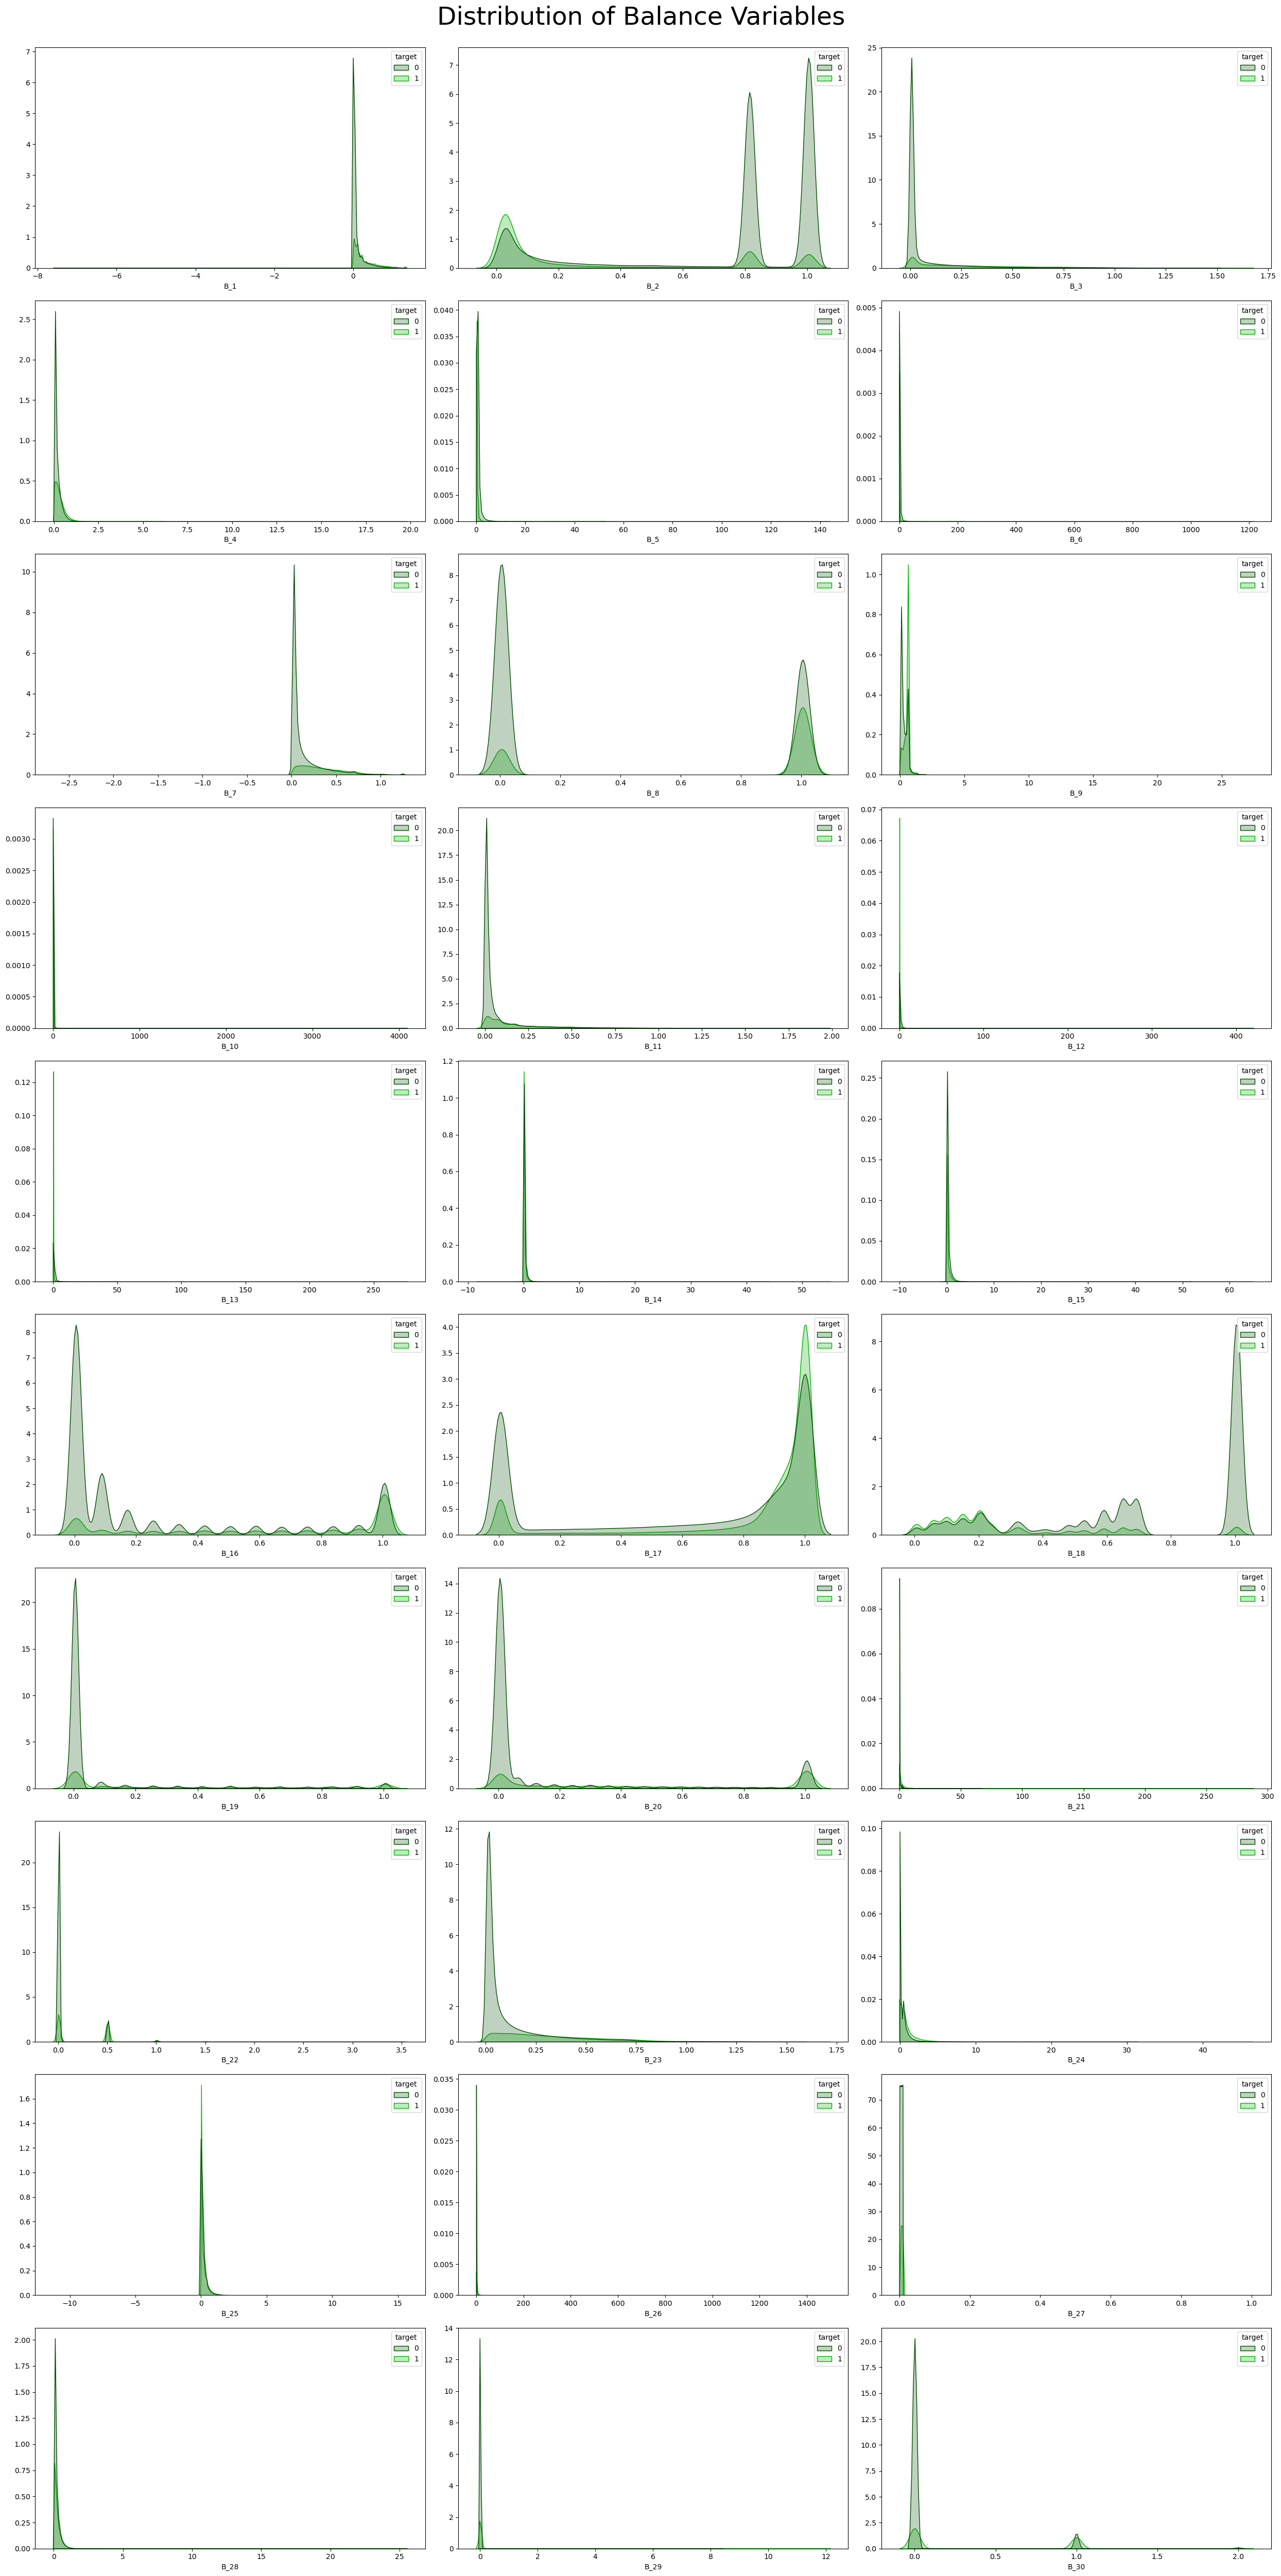

In [8]:
fig, axes = plt.subplots(10, 3, figsize = (25,50))
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(bal_cols):
        sns.kdeplot(x = bal_cols[i], hue='target', data = df_bal, fill = True, ax = ax, palette =["#004d00","#00b300"], warn_singular=False)
        ax.tick_params()
        ax.xaxis.get_label()
        ax.set_ylabel('')
fig.suptitle('Distribution of Balance Variables', fontsize = 35, x = 0.5, y = 1)
plt.tight_layout()
plt.show()

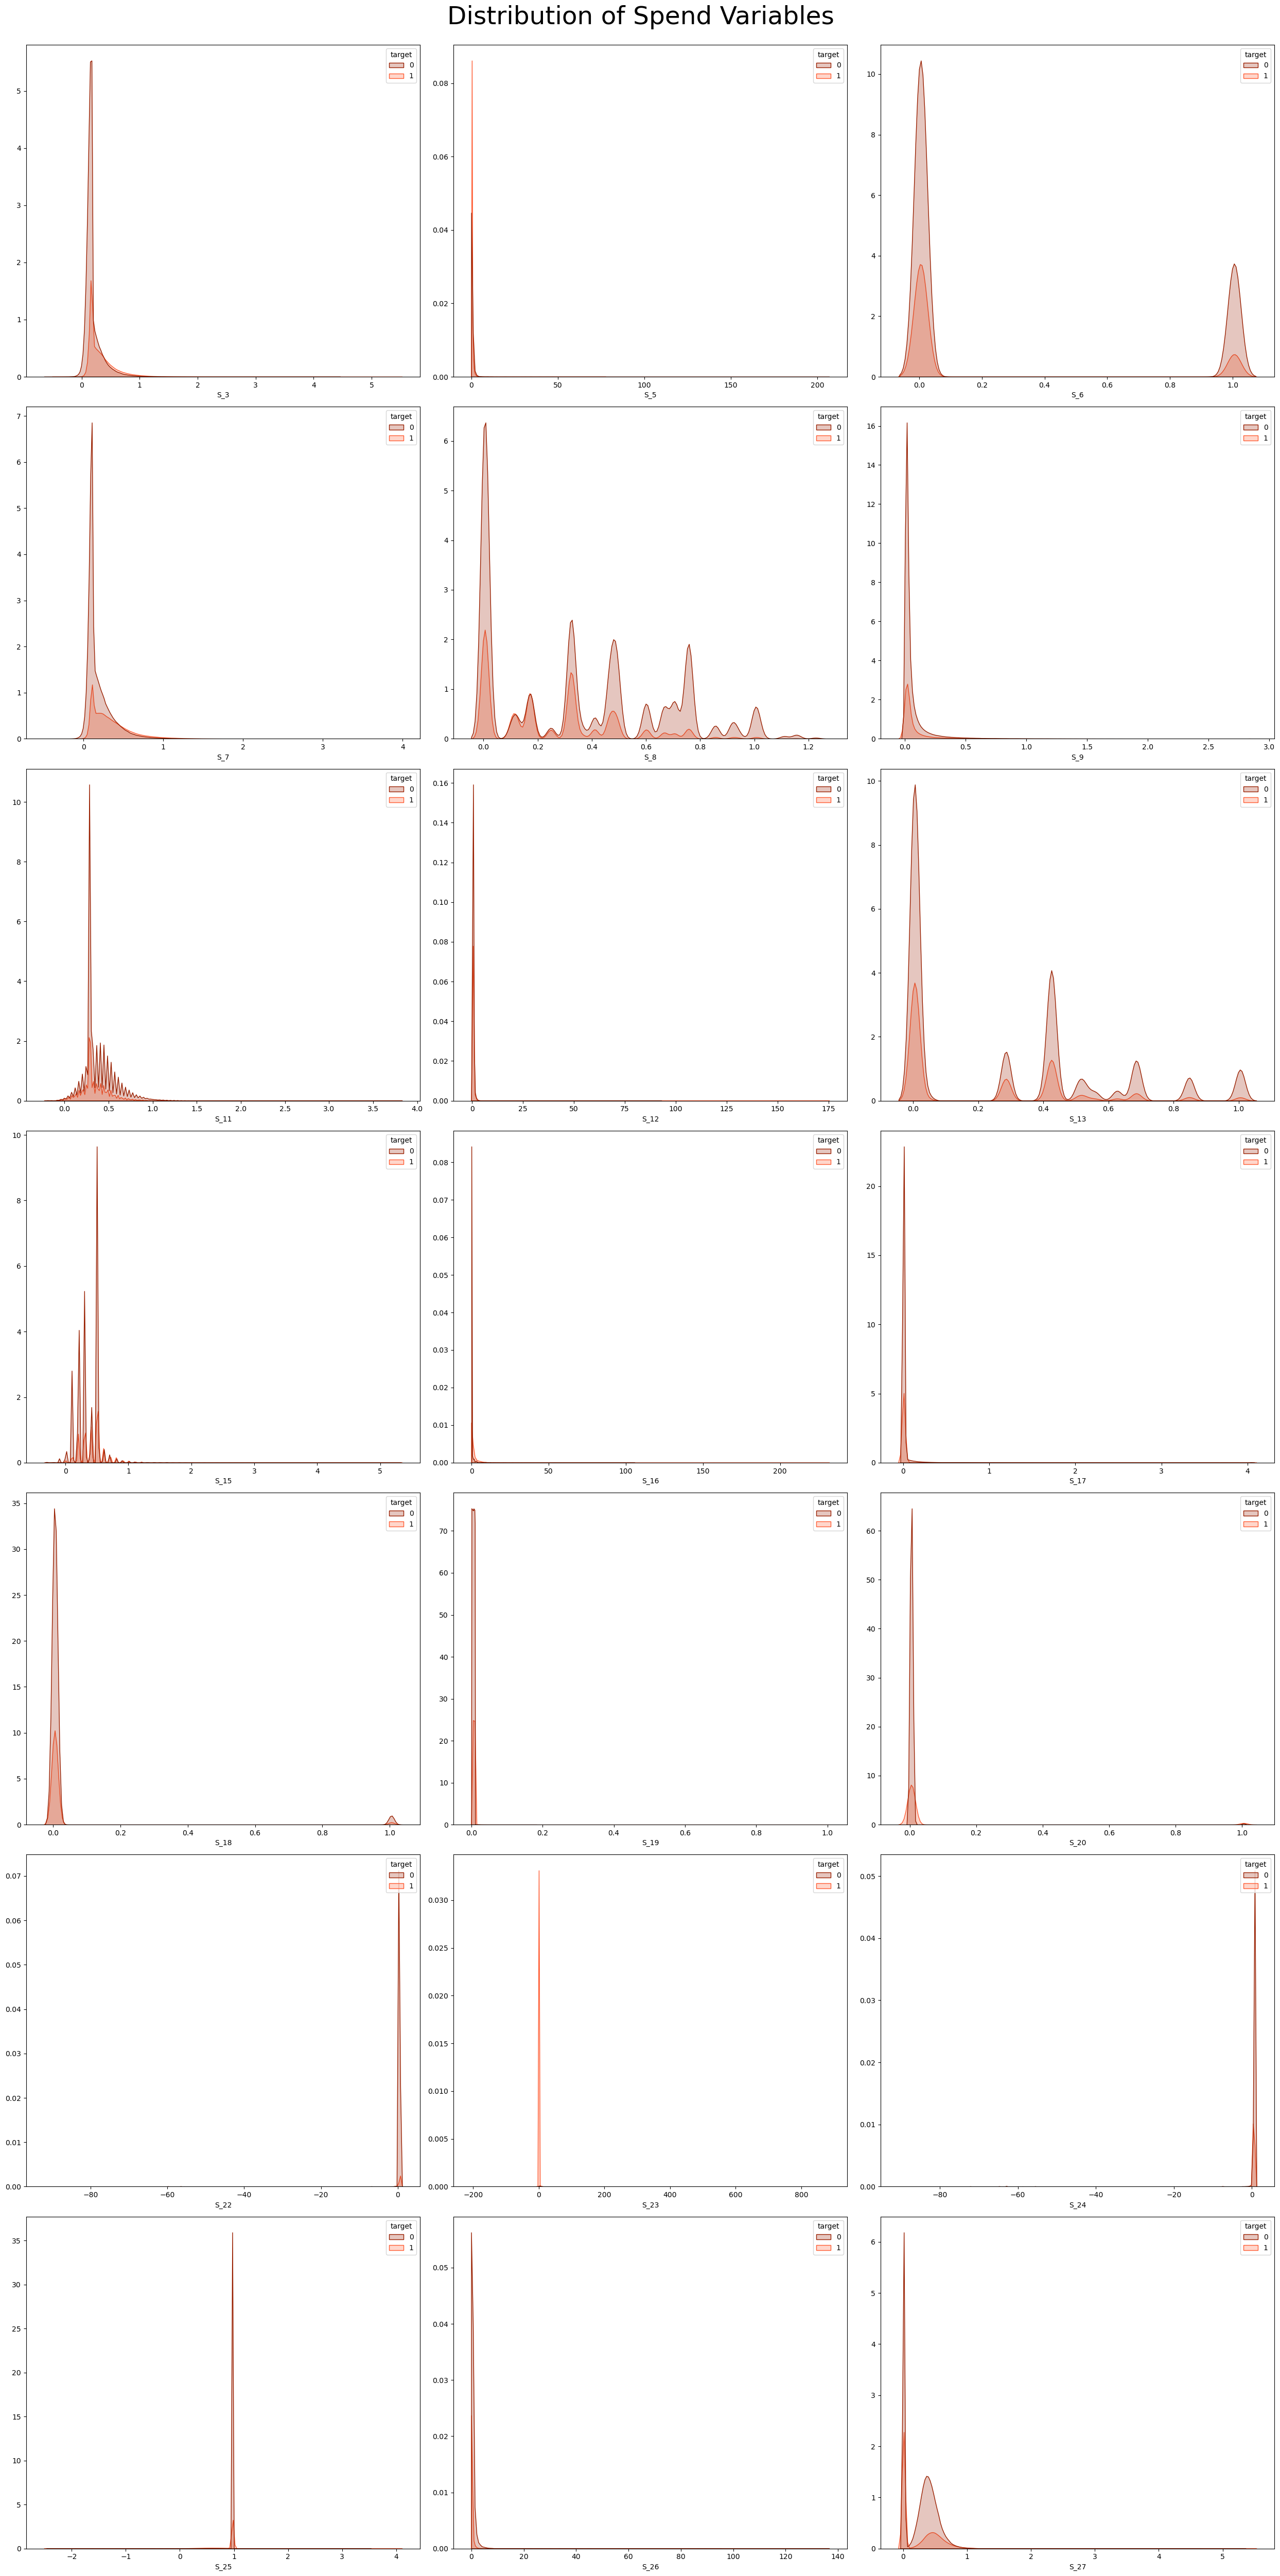

In [9]:
fig, axes = plt.subplots(7, 3, figsize = (25,50))
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(spd_cols):
        if spd_cols[i] != 'S_2':
            sns.kdeplot(x = spd_cols[i], hue='target', data = df_spd, fill = True, ax = ax, palette =["#991f00","#ff5c33"], warn_singular=False)
            ax.tick_params()
            ax.xaxis.get_label()
            ax.set_ylabel('')
        # end if
    # end if
# end for
fig.suptitle('Distribution of Spend Variables', fontsize = 35, x = 0.5, y = 1)
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  after removing the cwd from sys.path.


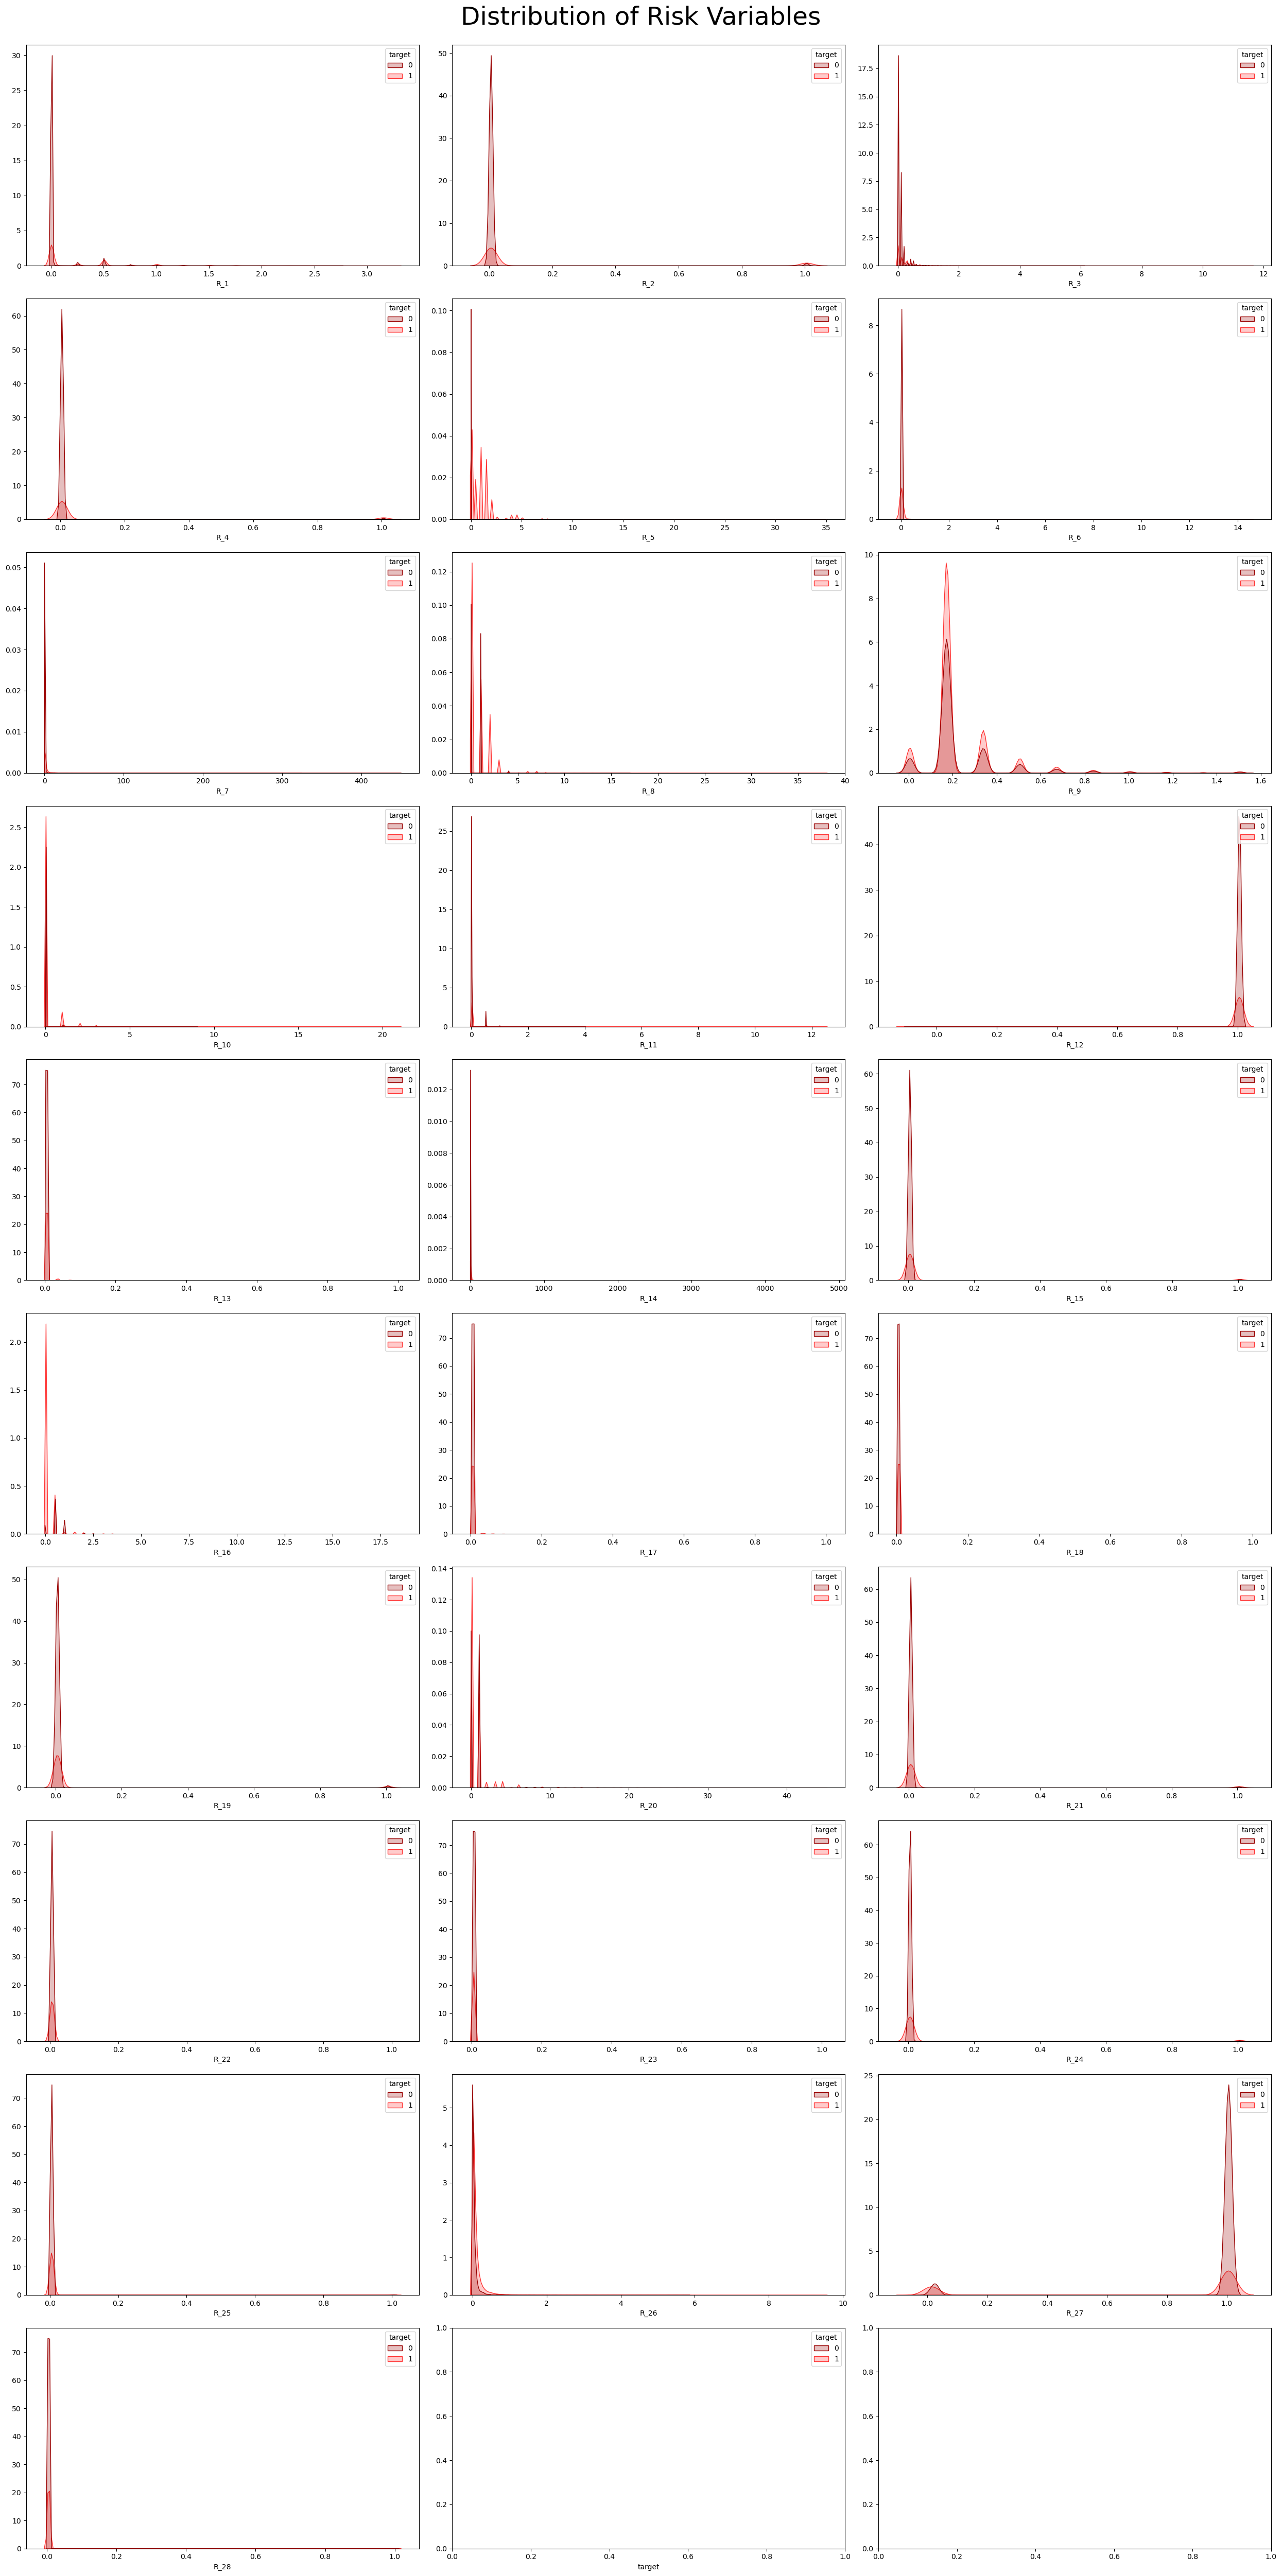

In [10]:
fig, axes = plt.subplots(10, 3, figsize = (25,50))
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(ris_cols):
        sns.kdeplot(x = ris_cols[i], hue='target', data = df_ris, fill = True, ax = ax, palette =["#990000","#ff3333"])
        ax.tick_params()
        ax.xaxis.get_label()
        ax.set_ylabel('')
fig.suptitle('Distribution of Risk Variables', fontsize = 35, x = 0.5, y = 1)
plt.tight_layout()
plt.show()